## AI Opening Case Study

In [147]:
# load important stuff
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# These are some new scikit learn toys that will make your life easier (see below)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline

### Read data

In [148]:
import os 
os.chdir ('/Users/hainayan/Downloads')

In [149]:
covid = pd.read_csv('Covid19_SourceFile.csv')
sample = pd.read_csv('1000AnalyticFileSample.csv')
dx = pd.read_csv('ICD10_Dx_TaxonomyTree.csv')
age = pd.read_csv('age.csv')

In [150]:
age.head()

,AgeCode,AgeGroup,Map to
0,1,Under 1,RefUnder18
1,2,1月17日,RefUnder18
2,3,18-24,Age_18_39
3,4,25-29,Age_18_39
4,5,30-34,Age_18_39


In [151]:
sample.head()

,Patient ID,Mortality (1= death),Age_18_39,Age_40_49,Age_50_59,Age_60_69,Age_70_74,Age_75_99,Gender_Male,BEHAV_AdjustmentStress,...,UROLG_GEN_Kidney,UROLG_GEN_Other_Nos_A,UROLG_GEN_Other_Nos_B,UROLG_GEN_Pers_Fam_Hx_Ds,UROLG_GEN_Screening,UROLG_GEN_Service,UROLG_GEN_Sgn_Symp,UROLG_GEN_Status_A,UROLG_GEN_Status_B,UROLG_GEN_Status2
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
dx.head()

,ICD10 Dx Code,ICD10 Dx Code Desc,DGL_1_Desc,DGL_2_Desc,DGL_3_Extend
0,F4320,"Adjustment disorder, unspecified",behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
1,F4322,Adjustment disorder with anxiety,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
2,F4323,Adjustment disorder with mixed anxiety and dep...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
3,F4324,Adjustment disorder with disturbance of conduct,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress
4,F4325,Adjustment disorder w mixed disturb of emotion...,behav - adjustment stress - adjustment ds - a...,behav - adjustment stress - adjustment ds,BEHAV_AdjustmentStress


In [153]:
covid.head()

,Patient ID,AgeCode,SexCode,DX1,DX2,DX3,DX4,DX5,DX6,DX7,...,DX12,DX13,DX14,DX15,DX16,DX17,DX18,DX19,DX20,Mortality (1= death)
0,1,13,2.0,L600,J45909,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,11,2.0,Z86010,K5730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,12,2.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,10,1.0,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,13,2.0,Z1211,I4901,Z95810,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Data Preparation

#### convert gender variable

In [154]:
covid = covid.replace({'SexCode': 2.0}, 0)
covid['SexCode'] = covid['SexCode'].fillna(0)
convert_dict = {'SexCode': int
               } 
covid = covid.astype(convert_dict) 
covid = covid.rename(columns={'SexCode': 'Gender_Male'})
covid.Gender_Male[covid.Gender_Male == 0] = 'Female'
covid.Gender_Male[covid.Gender_Male == 1] = "Male"

/Users/hainayan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


#### map age

In [155]:
covid_age = pd.merge(covid,
                 age[['AgeCode', 'Map to ']],
                 on='AgeCode')
covid_age

,Patient ID,AgeCode,Gender_Male,DX1,DX2,DX3,DX4,DX5,DX6,DX7,...,DX13,DX14,DX15,DX16,DX17,DX18,DX19,DX20,Mortality (1= death),Map to
0,1,13,Female,L600,J45909,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
1,5,13,Female,Z1211,I4901,Z95810,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
2,11,13,Male,K2270,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
3,13,13,Female,R1310,K319,G4733,I10,I4891,J4520,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Age_70_74
4,20,13,Female,Z86010,D125,I10,E119,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
5,21,13,Female,Z1211,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
6,25,13,Female,H2512,I4510,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
7,30,13,Male,Z1211,D124,D125,D128,J449,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
8,33,13,Female,Z86010,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74
9,43,13,Male,Z1211,D122,D125,K5730,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Age_70_74


In [156]:
covid_age = covid_age.drop(['AgeCode'],axis=1) 
covid = covid_age
covid = covid.sort_values(by=['Patient ID'])

##### check column with all nulls

In [157]:
print(covid.isnull().all())

Patient ID              False
Gender_Male             False
DX1                     False
DX2                     False
DX3                     False
DX4                     False
DX5                     False
DX6                     False
DX7                     False
DX8                     False
DX9                     False
DX10                    False
DX11                    False
DX12                    False
DX13                    False
DX14                    False
DX15                    False
DX16                    False
DX17                    False
DX18                    False
DX19                    False
DX20                    False
Mortality (1= death)    False
Map to                  False
dtype: bool


#### convert code of dx to class name

In [158]:
names = ['DX1',
 'DX2',
 'DX3',
 'DX4',
 'DX5',
 'DX6',
 'DX7',
 'DX8',
 'DX9',
 'DX10',
 'DX11',
 'DX12',
 'DX13',
 'DX14',
 'DX15',
 'DX16',
 'DX17',
 'DX18',
 'DX19',
 'DX20',]
for name in names:
    covid[name] = covid[name] .map(dx.set_index('ICD10 Dx Code')['DGL_3_Extend'])

### Modeling

#### Text analysis

##### Most frequently appearing diseases of death

In [159]:
death = covid[covid['Mortality (1= death)']==1]
text=death.iloc[:,0:25]
text = text.drop(['Mortality (1= death)'],axis=1) 
text = text.melt(id_vars = 'Patient ID')
text = text.iloc[:,2]text = text.dropna()
words = text.to_json()

SyntaxError: invalid syntax (<ipython-input-159-4c36fc9e49d2>, line 5)

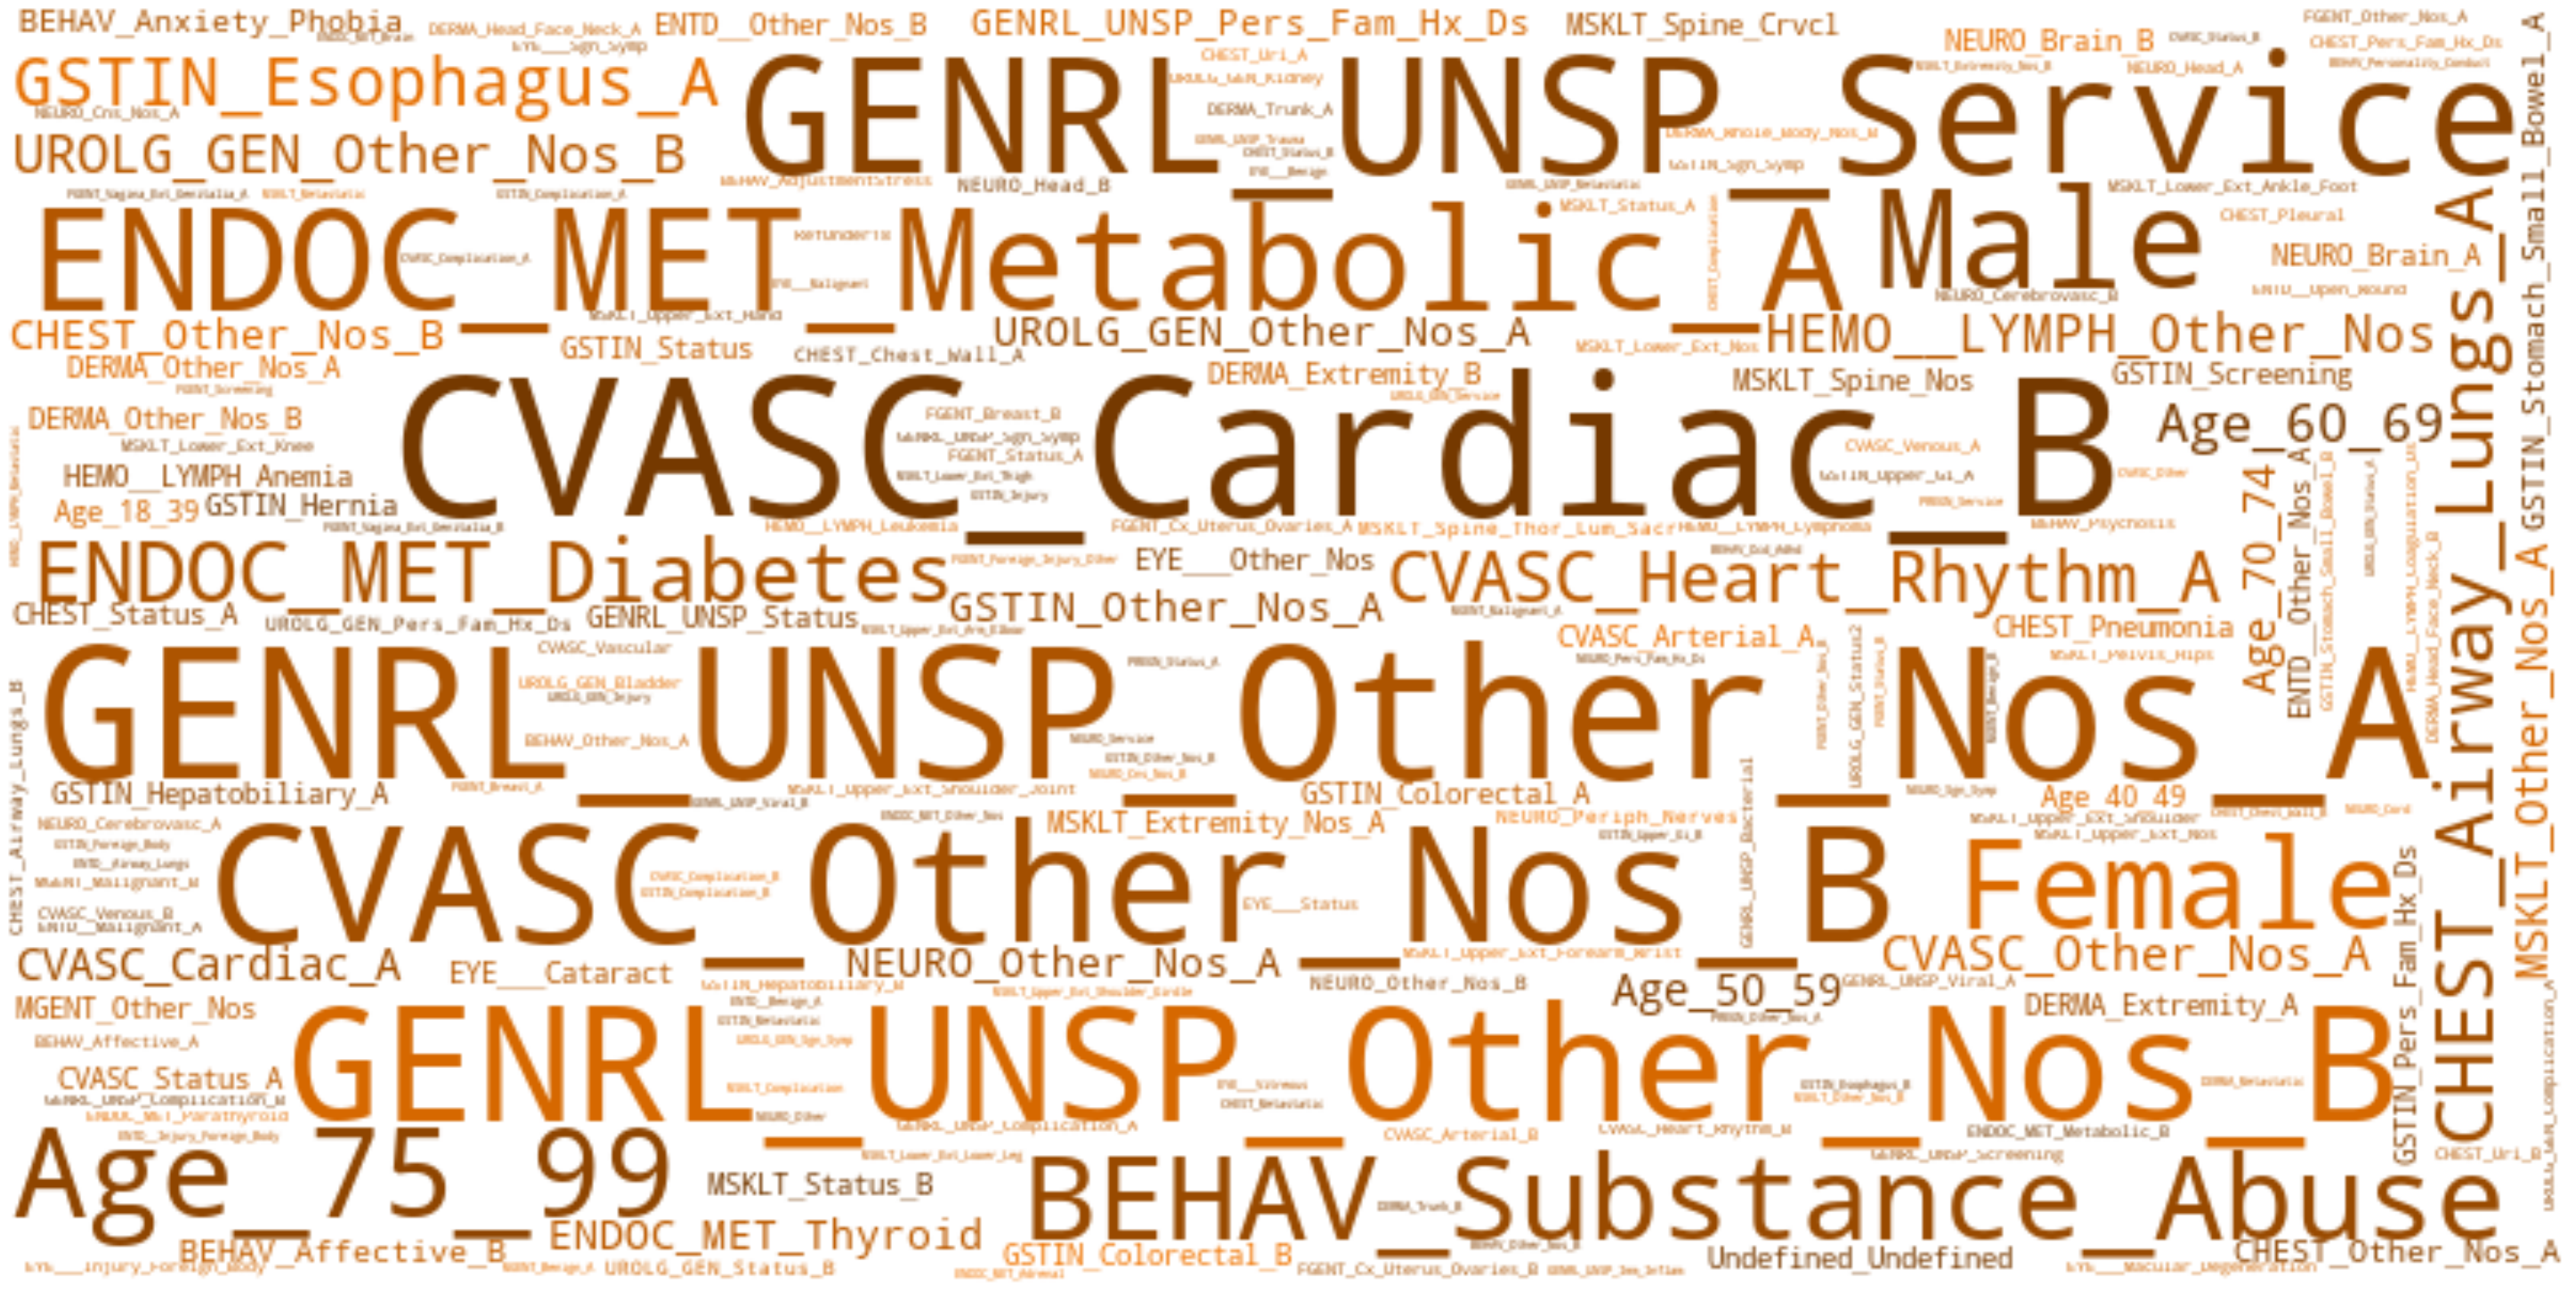

In [143]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def generate_wordcloud(word):
    word_cloud = WordCloud(width=800, height=400,background_color='white',max_font_size=60, collocations=False,stopwords=STOPWORDS,color_func=random_color_func).generate(words)
    plt.figure(figsize=(40,40),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_wordcloud(words)